In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# !!! Change the Filename accordingly !!!

In [2]:
figure_name = 'figures/fig_7_1_input_'

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d

from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

mpl.rcParams['figure.figsize'] = [20.0, 10.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 400


drawing_size = 25


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'oblique'
mpl.rcParams['font.weight']= 'heavy'
mpl.rcParams['font.family'] =  ['DejaVu Sans']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.3)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.3)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'

# print(mpl.rcParams.keys())


In [4]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 4.0 # -> 40ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 3.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

############################################################
#                 GABA neuron parameter                    #
#  parameters for p_gaba inhibitory neuron of LSO, all marked by a _p #
############################################################
tau_p = 25
alpha_p = 10.0
beta_p = 10.0

In [5]:
############################################################
#                       Functions                          #
############################################################

def mesh_plot(data,ax):
    # fig is the figure handler
    # data is a 2d array
    # returns the axis of the figure

    # import necessary modules
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.pyplot as plt
    # define x and y axis
    x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), data.shape[0])
    y = np.linspace(np.min(data[1, :]), np.max(data[1, :]), data.shape[1])
    # x = np.linspace(0, 1, data.shape[0])
    # y = np.linspace(0, 1, data.shape[1])
    x, y = np.meshgrid(x, y)

    # plot data with nice colors
    ax1.plot_surface(
        x,
        y,
        data.T,
        rstride=1,
        cstride=1,
        cmap=cm.viridis,
        shade=True,
        linewidth=20)

    return ax




#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.20):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.maximum(q_pc,0)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # do a subtractive inhibition, this is done by subtracting the g_r_out values from the kernel weights
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel

    ee_kernel  = ee_kernel*(1-gaba_exc)
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) #*  1/(np.exp(gaba_exc))
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    ei_kernel  = ei_kernel*(1-gaba_inh)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) #* 1/(np.exp(gaba_inh))
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q

# Defines the ODE for the p_gaba neuron which defines the strength of the modulation (inhibition) of the inputs of the r neuron
def ode_p_pc(p_gaba, r_gbc):
    # get the globally defined parameters
    global tau_p,alpha_p,beta_p

    d_p_pc =   -alpha_p*p_gaba +(beta_p - p_gaba)*g_r_out(r_gbc)  
    return  d_p_pc  / tau_p



# Input

In [6]:

# GABA parameter
sbc_input_intensities = np.linspace(1.0,0.0,8)
gbc_input_intensities = np.linspace(0.0,1.0,8)

adaptor_tone =np.linspace(1,0.0,4)


# store values for different parameters
q_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))
r_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))
p_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))

gaba_inh_values = np.zeros((len(t),freq_bands))
gaba_exc_values = np.zeros((len(t),freq_bands))


############################################################
#                      Simulation                          #
############################################################
s_gbc_all_all = np.zeros((len(adaptor_tone),len(sbc_input_intensities),len(t),freq_bands))
s_sbc_all_all = np.zeros((len(adaptor_tone),len(sbc_input_intensities),len(t),freq_bands))
for l in range(len(adaptor_tone)):
    for k in range(len(sbc_input_intensities)):

        ############################################################
        #                       Inputs                             #
        ############################################################
        s_gbc_all= np.zeros((len(t),freq_bands))
        s_sbc_all = np.zeros((len(t),freq_bands))

        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        sigma = 1.0

        ### MNTB inhibitory input (contra-lateral) ###
        gbc_center_frequencyBand =2
        gbc_input_strength = gbc_input_intensities[k]
            
        # build ramps
        time_window = 400
        for i in range(time_window,len(t)-time_window-2050,time_window):
            s_gbc_all[i:i+time_window,gbc_center_frequencyBand] = 0 

        for i in range(len(t)-time_window-1500,len(t)-100,time_window):
            s_gbc_all[i:i+time_window,gbc_center_frequencyBand] = 1 * gbc_input_strength


        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
        gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
        s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')


        # LSO direct excitatory input (ipsi-lateral)
        sbc_center_frequencyBand = 2
        sbc_input_strength = sbc_input_intensities[k]

        # build ramps
        for i in range(time_window,len(t)-time_window-2050,time_window):
            s_sbc_all[i:i+time_window,sbc_center_frequencyBand] = adaptor_tone[l]

        for i in range(len(t)-time_window-1500,len(t)-100,time_window):
            s_sbc_all[i:i+time_window,sbc_center_frequencyBand] = 1 * sbc_input_strength


        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
        sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
        s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')


        # Convolve with gauss curve to build a temporal ramp
        s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
        s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

        # normalize input
#         maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
#         s_gbc_all /= maxi
#         s_sbc_all /= maxi

        s_gbc_all /= 100
        s_sbc_all /= 100
        
        s_gbc_all_all[l,k] = s_gbc_all
        s_sbc_all_all[l,k] = s_sbc_all
        

#         for i in range(0, len(t)-1):
#                 for w in range(0,freq_bands):
                    # E-E kernel
#                     ee_kernel = gauss(np.arange(freq_bands),w,0.5)
#                     ei_kernel = gauss(np.arange(freq_bands),w,0.1)
#                     ie_kernel = gauss(np.arange(freq_bands),w,0.1)
#                     ii_kernel = gauss(np.arange(freq_bands),w,1.0)

#                     # normalize it 
#                     ee_kernel /= np.max(ee_kernel)
#                     ei_kernel /= np.max(ie_kernel)
#                     ie_kernel /= np.max(ie_kernel)
#                     ii_kernel /= np.max(ie_kernel)

#                     # calculate GABA inhibition and store the values for later inspection (later do that in ode_r_bpc function)

#                     gaba_inh_values[i,w] =   p_all[l,k,i,w]*1
#                     gaba_exc_values[i,w] =   p_all[l,k,i,w]*5




#                     delay_factor = 20
#                     # as an MNTB input we use the value of the previously calculated time step. 
#                     # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
#                     if i < delay_factor:
#                         r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[3]),ei_kernel,spf_r,gaba_exc_values[i,w],gaba_inh_values[i,w])       
#                     else:
#                         r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,q_all[l,k,i-delay_factor,:],ei_kernel,spf_r,gaba_exc_values[i,w],gaba_inh_values[i,w])       

#                     q_all[l,k,i+1,w] = q_all[l,k,i,w] +  dt * ode_q_pc(q_all[l,k,i,w],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)

#                     p_all[l,k,i+1,w] = p_all[l,k,i,w] + dt * ode_p_pc(p_all[l,k,i,w],g_r_out(r_all[l,k,i,w]))






#         plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
#         plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')        

# plt.ylabel('Input Level')       
# plt.xlabel('Time ')
# plt.show()

[-0.2  0.   0.2  0.4  0.6  0.8  1.   1.2]


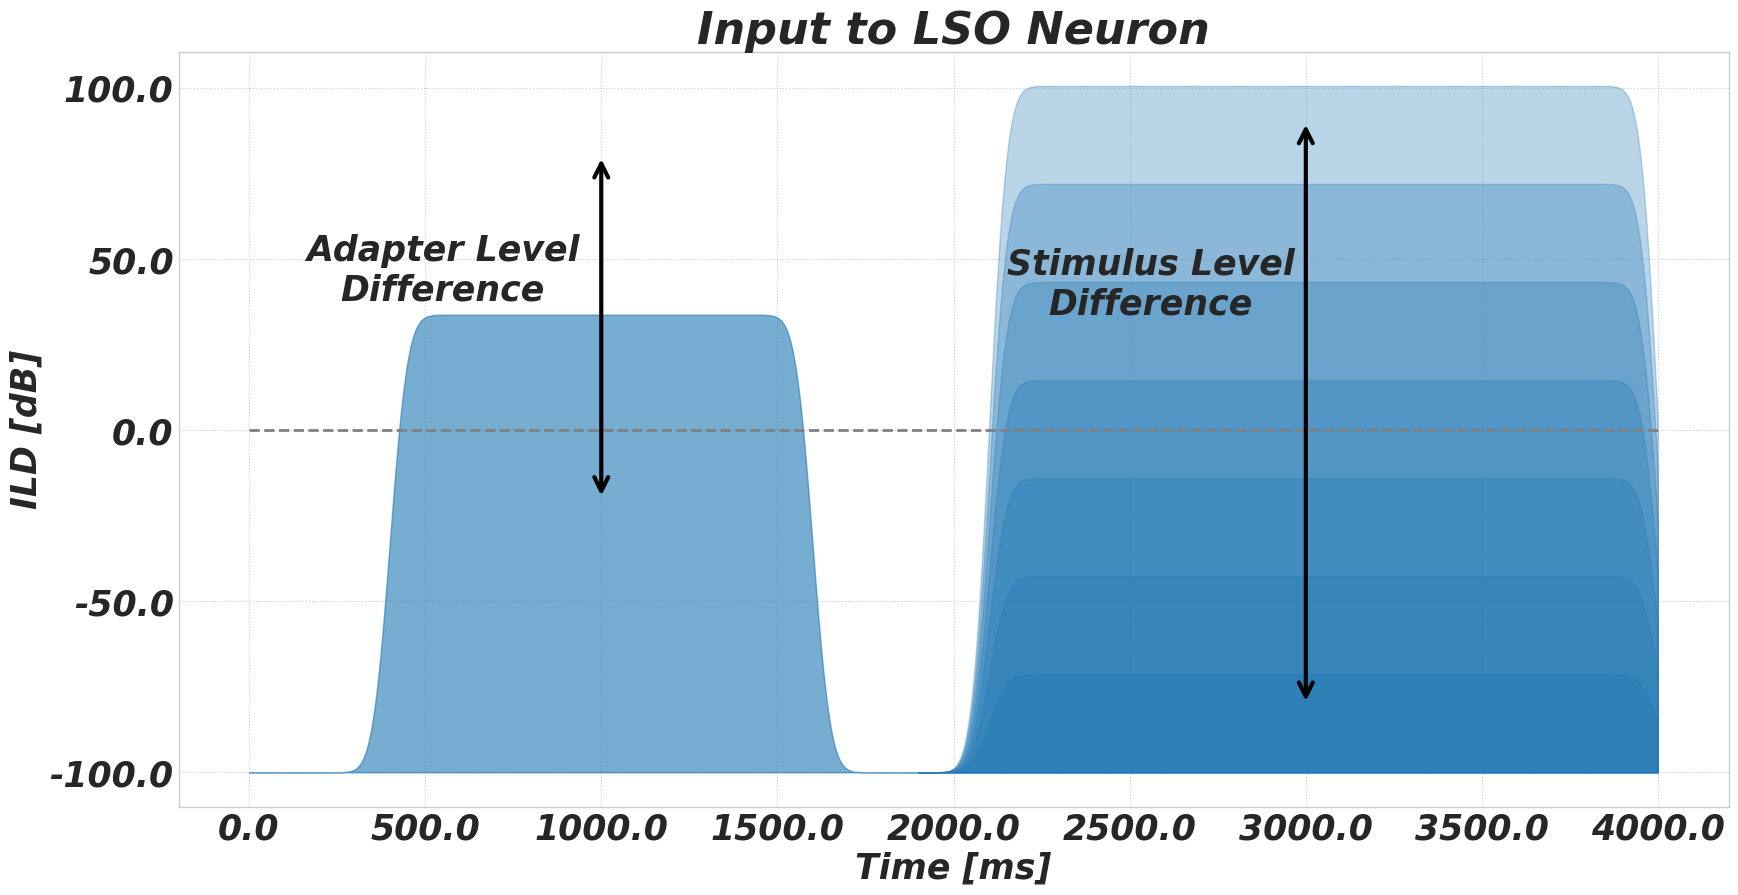

[-50.   0.  50.]


In [45]:
# Define the times when to probe
probing_times = [1400]
# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]


# fig = plt.figure(figsize=(10,5))
fig = plt.figure()


plotting_range = np.arange(0,1900)
## show LSO neuron response
ax2 = fig.add_subplot(111)
l = 0
adaptor_levels = [1]
for j in adaptor_levels:
    if l == 0 :
        line_style = '-'
        line_color = 'C0'
        face_color = 'C0'
    elif l == 1:
        line_style = '-'
        line_color = 'C1'
        face_color = 'C1'

    else:
        line_style = '-'
        line_color = 'C2'
        face_color = 'C2'

    l +=1
    for i in range(1,2):
        tmp = s_sbc_all_all[j,i,:,sbc_center_frequencyBand]
        # normalize it
    #     tmp = tmp -  np.min(tmp)
    #     tmp = tmp / np.max(tmp)
#         ax2.plot(t[plotting_range]*1000,tmp[plotting_range],linestyle=line_style,color=line_color,label='Level Difference = {0:.1f}'.format(sbc_input_intensities[i]-gbc_input_intensities[i]))
        ax2.fill_between(t[plotting_range]*1000,tmp[plotting_range], 0, color = face_color, alpha=0.6,label='Adaptor Level : {0:.1f}'.format(adaptor_tone[j]))


plotting_range = np.arange(1900,4000)
## show LSO neuron response
for j in adaptor_levels[::-1]:
    l -=1
    if l == 0 :
        line_style = '-'
        line_color = 'C0'
        face_color = 'C0'
    elif l == 1:
        line_style = '-'
        line_color = 'C1'
        face_color = 'C1'

    else:
        line_style = '-'
        line_color = 'C2'
        face_color = 'C2'

    for i in range(len(sbc_input_intensities)):
        tmp = s_sbc_all_all[j,i,:,sbc_center_frequencyBand]

#         ax2.plot(t[plotting_range]*1000,tmp[plotting_range],linestyle=line_style,color=line_color)
        ax2.fill_between(t[plotting_range]*1000,tmp[plotting_range], 0, color = face_color,  alpha=0.3)
        
        
ax2.annotate("", xy=(1000, 0.90), xytext=(1000, 0.40),arrowprops=dict(arrowstyle="<->",linewidth=3))
ax2.annotate("Adapter Level\nDifference", xy=(900, 0.66), xytext=(550, 0.68),horizontalalignment='center',verticalalignment='bottom')

ax2.annotate("", xy=(3000, 0.95), xytext=(3000, 0.10),arrowprops=dict(arrowstyle="<->",linewidth=3))
ax2.annotate("Stimulus Level\nDifference", xy=(2560, 0.66), xytext=(2560, 0.66),horizontalalignment='center',verticalalignment='bottom')

ax2.hlines(0.5,0,4000,linestyles='--',linewidth=2,color='grey')


ax2.invert_xaxis()
plt.title('Input to LSO Neuron')
plt.ylabel('ILD [dB]')
plt.xlabel('Time [ms]')
ax2.set_xticklabels([ float(k ) for k in ax2.get_xticks()])
print(ax2.get_yticks())
# ax2.set_yticks(list(ax2.get_yticks()) + [0.5])
ax2.set_yticks( [0. ,  0.25 , 0.5 , 0.75 , 1. ])
ax2.set_yticklabels(np.linspace(-100,100,len(ax2.get_yticks()),endpoint=True))
ax2.invert_xaxis()
# plt.legend()


plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

mpl.rcParams['figure.figsize'] = [20.0, 10.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 400


drawing_size = 25


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'oblique'
mpl.rcParams['font.weight']= 'heavy'
mpl.rcParams['font.family'] =  ['DejaVu Sans']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.3)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.3)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'

plt.savefig(figure_name + 'input_stimuli.svg', bbox_inches='tight')
plt.savefig(figure_name + 'input_stimuli.pdf',bbox_inches='tight')
plt.show()


print(np.linspace(-50,50,len(ax2.get_yticks())-2,endpoint=True,))
